## Import packages

In [1]:
import sys
print(sys.version)

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms import v2

import os
import pandas as pd

from PIL import Image
import rasterio

3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:40:50) [MSC v.1937 64 bit (AMD64)]


## Import the tabular data

In [2]:
# list the .csv files in the folder
# for root, dirs, files in os.walk('../'):
#     for file in files:
#         if file.endswith('.csv'):
#             print(file)

In [3]:
# Specify the path to your CSV file
csv_file_path = '../buffalo_data_df_lag_1hr_n10000.csv'

# Read the CSV file into a DataFrame
buffalo_df = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
print(buffalo_df.head())

             x_            y_                    t_    id           x1_  \
0  41968.357479 -1.435673e+06  2018-07-25T01:04:23Z  2005  41968.357479   
1  41920.568545 -1.435656e+06  2018-07-25T02:04:39Z  2005  41920.568545   
2  41778.486205 -1.435602e+06  2018-07-25T03:04:17Z  2005  41778.486205   
3  41840.249881 -1.435637e+06  2018-07-25T04:04:39Z  2005  41840.249881   
4  41654.509951 -1.435606e+06  2018-07-25T05:04:27Z  2005  41654.509951   

            y1_           x2_           y2_     x2_cent    y2_cent  ...  \
0 -1.435673e+06  41920.568545 -1.435656e+06  -47.788934  16.857104  ...   
1 -1.435656e+06  41778.486205 -1.435602e+06 -142.082340  53.568411  ...   
2 -1.435602e+06  41840.249881 -1.435637e+06   61.763676 -34.322931  ...   
3 -1.435637e+06  41654.509951 -1.435606e+06 -185.739930  31.003515  ...   
4 -1.435606e+06  41617.698545 -1.435610e+06  -36.811406  -4.438040  ...   

  yday_t2          sl    log_sl   bearing        ta    cos_ta         x_min  \
0     206   50.6748

In [44]:
# extract the step length and turning angle columns, which will be our target
sl_ta = buffalo_df[['log_sl', 'ta']].values
print(sl_ta)


[[ 3.92543047  1.36794199]
 [ 5.02286161 -0.02142933]
 [ 4.25787761  2.99491689]
 ...
 [ 0.35233755  0.24323115]
 [ 0.42446601 -3.08306273]
 [ 1.42263024  1.08084533]]


[ 50.67488746 151.8452041   70.65985635 ...   1.42238856   1.52877385
   4.1480164 ]
(array([3.10e+03, 5.58e+02, 4.05e+02, 2.79e+02, 2.60e+02, 2.84e+02,
       2.46e+02, 2.37e+02, 2.18e+02, 2.15e+02, 2.06e+02, 2.08e+02,
       1.89e+02, 1.85e+02, 1.77e+02, 1.41e+02, 1.66e+02, 1.55e+02,
       1.38e+02, 1.61e+02, 1.20e+02, 1.23e+02, 1.08e+02, 1.08e+02,
       9.70e+01, 8.50e+01, 8.00e+01, 6.90e+01, 7.60e+01, 7.10e+01,
       6.70e+01, 8.00e+01, 6.10e+01, 6.80e+01, 6.20e+01, 4.50e+01,
       6.20e+01, 5.30e+01, 5.80e+01, 3.70e+01, 4.20e+01, 4.90e+01,
       3.10e+01, 2.70e+01, 2.80e+01, 3.30e+01, 3.20e+01, 2.80e+01,
       3.50e+01, 2.70e+01, 2.80e+01, 2.10e+01, 1.60e+01, 1.90e+01,
       1.90e+01, 2.20e+01, 1.60e+01, 1.90e+01, 2.20e+01, 1.30e+01,
       8.00e+00, 1.70e+01, 1.40e+01, 1.50e+01, 1.50e+01, 1.50e+01,
       8.00e+00, 8.00e+00, 8.00e+00, 1.20e+01, 9.00e+00, 6.00e+00,
       7.00e+00, 3.00e+00, 4.00e+00, 7.00e+00, 9.00e+00, 7.00e+00,
       1.00e+01, 8.00e+00, 2.00e+00, 6.00e+

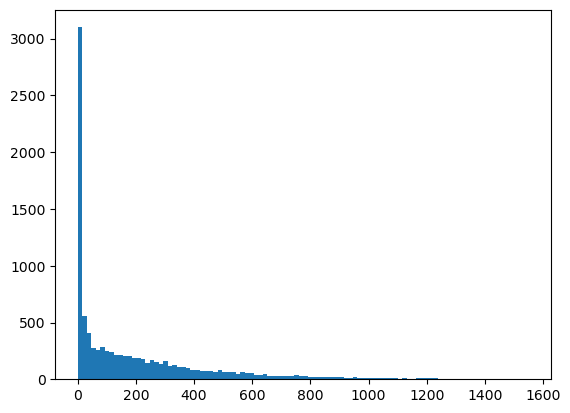

In [45]:
# extract just the step length column
sl = buffalo_df['sl'].values
print(sl)
print(plt.hist(sl, bins=100))

[3.92543047 5.02286161 4.25787761 ... 0.35233755 0.42446601 1.42263024]
(array([  2.,   2.,   2.,   0.,   2.,   1.,   4.,   2.,   2.,   2.,   4.,
         4.,   7.,   6.,  10.,  13.,  16.,  10.,  14.,  27.,  27.,  29.,
        30.,  39.,  43.,  51.,  60.,  64.,  88.,  84.,  95., 100., 107.,
       148., 153., 114., 166., 151., 155., 149., 150., 154., 138., 121.,
       141., 107., 115., 103.,  88.,  77.,  77.,  88.,  88.,  65.,  59.,
        64.,  58.,  91., 101.,  73., 107.,  90.,  82.,  92.,  84., 106.,
       127., 146., 144., 141., 140., 175., 159., 185., 190., 205., 215.,
       228., 224., 211., 240., 256., 244., 230., 196., 187., 187., 206.,
       184., 158., 137., 130., 116.,  94.,  82.,  65.,  40.,  46.,  21.,
         4.]), array([-1.66084917, -1.57077845, -1.48070774, -1.39063703, -1.30056631,
       -1.2104956 , -1.12042488, -1.03035417, -0.94028346, -0.85021274,
       -0.76014203, -0.67007132, -0.5800006 , -0.48992989, -0.39985917,
       -0.30978846, -0.21971775, -0.129

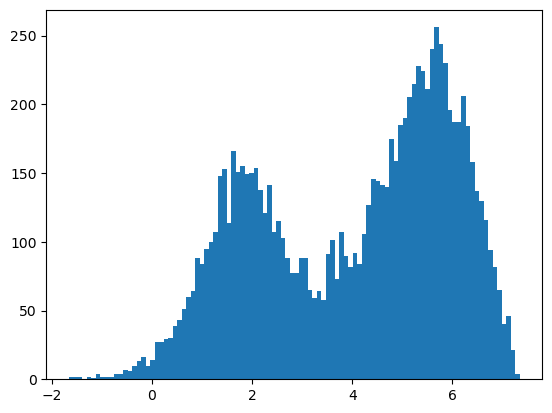

In [46]:
# take the log of the step length
log_sl = np.log(sl)
print(log_sl)
# plot a histogram of the log step length
print(plt.hist(log_sl, bins=100))

[ 1.36794199 -0.02142933  2.99491689 ...  0.24323115 -3.08306273
  1.08084533]


(array([126.,  93., 106.,  96.,  87.,  96.,  89.,  80.,  73.,  82.,  89.,
         94.,  78.,  78.,  85.,  70.,  76.,  86.,  70.,  84.,  75.,  79.,
         76.,  83.,  83.,  76.,  95.,  80.,  74.,  64., 110., 100.,  94.,
         78.,  99., 112.,  99., 103., 108., 102.,  99., 107., 107., 135.,
        146., 151., 132., 143., 133., 140., 140., 145., 140., 155., 136.,
        145., 124., 113., 108., 121., 110.,  85., 111., 129., 100., 106.,
         95.,  92.,  92.,  99.,  84.,  89.,  79.,  96.,  79.,  80.,  77.,
         74., 100.,  85.,  80.,  79.,  93.,  87.,  84., 107.,  92.,  80.,
         75.,  87.,  87., 100., 104.,  88., 101.,  90.,  89.,  91.,  96.,
         95.]),
 array([-3.14142455e+00, -3.07859737e+00, -3.01577018e+00, -2.95294300e+00,
        -2.89011581e+00, -2.82728863e+00, -2.76446144e+00, -2.70163426e+00,
        -2.63880708e+00, -2.57597989e+00, -2.51315271e+00, -2.45032552e+00,
        -2.38749834e+00, -2.32467116e+00, -2.26184397e+00, -2.19901679e+00,
        -2.136

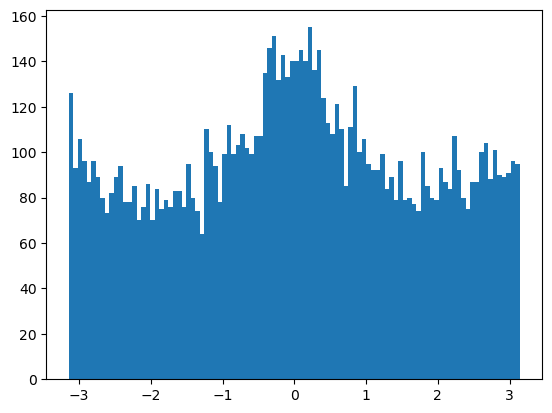

In [47]:
# extract just the turning angle column
ta = buffalo_df['ta'].values
print(ta)
# plot a histogram of the turning angle
plt.hist(ta, bins=100)

[ 0.20146596  0.9997704  -0.98926238 ...  0.97056485 -0.99828761
  0.47058265]


(array([638., 250., 177., 182., 132., 122., 124., 103.,  87., 100.,  89.,
         89.,  79.,  70.,  71.,  74.,  74.,  67.,  87.,  71.,  69.,  60.,
         57.,  71.,  54.,  58.,  71.,  66.,  55.,  54.,  55.,  39.,  60.,
         57.,  56.,  47.,  56.,  59.,  50.,  69.,  47.,  55.,  50.,  47.,
         52.,  47.,  53.,  50.,  44.,  61.,  39.,  55.,  51.,  62.,  61.,
         62.,  57.,  44.,  55.,  53.,  58.,  46.,  56.,  47.,  50.,  51.,
         81.,  66.,  70.,  70.,  66.,  57.,  66.,  77.,  45.,  79.,  69.,
         78.,  81.,  74.,  95.,  87.,  91.,  99.,  93., 102.,  90.,  92.,
         98., 115., 108., 124., 139., 134., 165., 193., 245., 280., 377.,
        907.]),
 array([-9.99999986e-01, -9.79999987e-01, -9.59999987e-01, -9.39999988e-01,
        -9.19999989e-01, -8.99999990e-01, -8.79999991e-01, -8.59999991e-01,
        -8.39999992e-01, -8.19999993e-01, -7.99999994e-01, -7.79999995e-01,
        -7.59999995e-01, -7.39999996e-01, -7.19999997e-01, -6.99999998e-01,
        -6.799

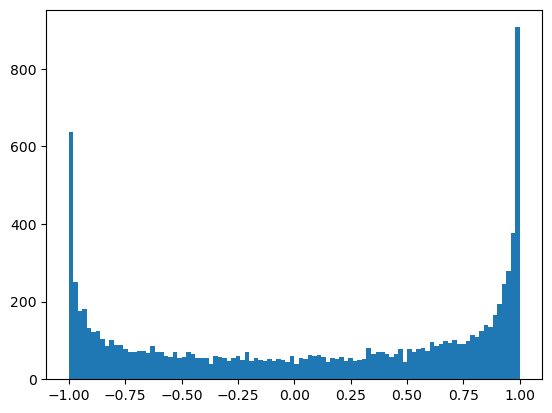

In [48]:
# take the cosine of the turning angle
cos_ta = np.cos(ta)
print(cos_ta)
# plot a histogram of the cosine of the turning angle
plt.hist(cos_ta, bins=100)

In [9]:
# combine the 

In [49]:
# convert to a tensor
sl_ta = torch.tensor(sl_ta, dtype=torch.float32)
print(sl_ta)

tensor([[ 3.9254,  1.3679],
        [ 5.0229, -0.0214],
        [ 4.2579,  2.9949],
        ...,
        [ 0.3523,  0.2432],
        [ 0.4245, -3.0831],
        [ 1.4226,  1.0808]])


## Importing spatial data

In [50]:
# list the .tif files in the folder
for root, dirs, files in os.walk('../'):
    for file in files:
        if file.endswith('.tif'):
            print(file)

buffalo_canopy_cent100x100_lag_1hr_n1000.tif
buffalo_canopy_cent100x100_lag_1hr_n10000.tif
buffalo_canopy_cent100x100_lag_6hr_n10000.tif
buffalo_canopy_cent50x50_n10000.tif
buffalo_canopy_cent_n10000.tif
buffalo_herby_cent100x100_lag_1hr_n1000.tif
buffalo_herby_cent100x100_lag_1hr_n10000.tif
buffalo_herby_cent100x100_lag_6hr_n10000.tif
buffalo_herby_cent100x100_n10000.tif
buffalo_herby_cent50x50_n10000.tif
buffalo_herby_cent_n10000.tif
buffalo_ndvi_cent100x100_lag_1hr_n1000.tif
buffalo_ndvi_cent100x100_lag_1hr_n10000.tif
buffalo_ndvi_cent100x100_lag_6hr_n10000.tif
buffalo_ndvi_cent50x50_n10000.tif
buffalo_ndvi_cent_n10000.tif
buffalo_pres_cent100x100_lag_1hr_n1000.tif
buffalo_pres_cent100x100_lag_1hr_n10000.tif
buffalo_pres_cent100x100_lag_6hr_n10000.tif
buffalo_pres_cent50x50_n10000.tif
buffalo_pres_cent_n10000.tif
buffalo_slope_cent100x100_lag_1hr_n1000.tif
buffalo_slope_cent100x100_lag_1hr_n10000.tif
buffalo_slope_cent100x100_lag_6hr_n10000.tif
buffalo_slope_cent50x50_n10000.tif
buf

## NDVI

In [12]:
# Path to your TIF file
file_path = '../buffalo_ndvi_cent50x50_n10000.tif'
# with lag
# file_path = '../buffalo_ndvi_cent100x100_lag_6hr_n10000.tif'

# Using rasterio 
with rasterio.open(file_path) as ndvi:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    ndvi_stack = ndvi.read([i for i in range(1, ndvi.count + 1)])


In [13]:
print(ndvi_stack.shape)
# print(ndvi_stack.size)

ndvi_tens = torch.from_numpy(ndvi_stack)
print(ndvi_tens.shape)
print("Mean = ", torch.mean(ndvi_tens))

ndvi_max = torch.max(ndvi_tens)
ndvi_min = torch.min(ndvi_tens)

print("Max = ", ndvi_max)
print("Min = ", ndvi_min)

# Normalizing the data
ndvi_tens_norm = (ndvi_tens - ndvi_min) / (ndvi_max - ndvi_min)
print("Mean = ", torch.mean(ndvi_tens_norm))
print("Max = ", torch.max(ndvi_tens_norm))
print("Min = ", torch.min(ndvi_tens_norm))

# print(ndvi_tens_norm.dtype)


(9816, 100, 100)
torch.Size([9816, 100, 100])
Mean =  tensor(0.3054)
Max =  tensor(0.8220)
Min =  tensor(-0.2772)
Mean =  tensor(0.5301)
Max =  tensor(1.)
Min =  tensor(0.)


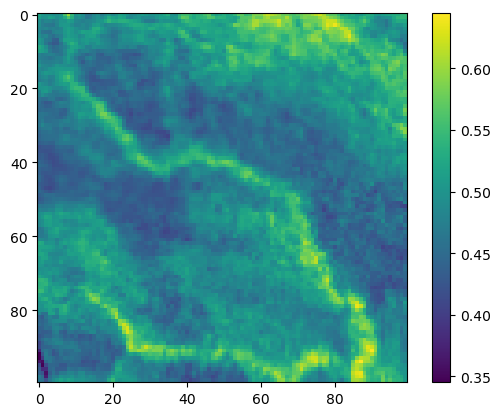

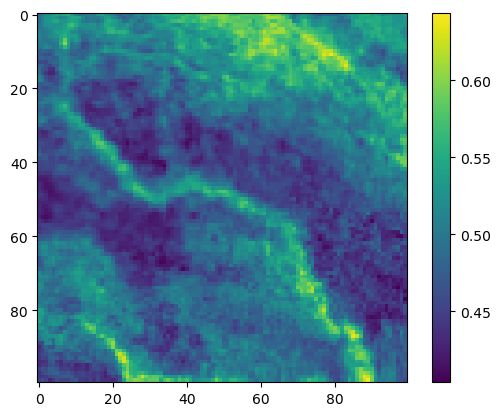

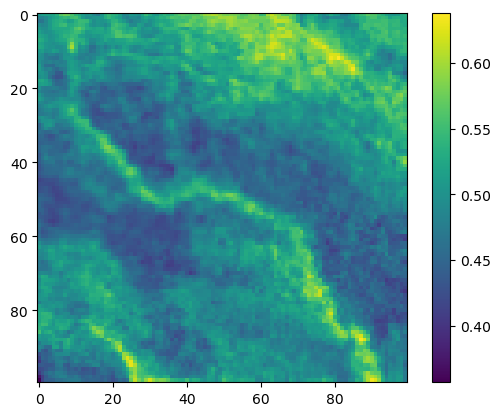

In [14]:
for i in range(0, 3):
    plt.imshow(ndvi_tens_norm[i].numpy())
    plt.colorbar()  
    plt.show()

## Canopy cover

In [15]:
# Path to your TIF file
file_path = '../buffalo_canopy_cent50x50_n10000.tif'
# with lag
# file_path = '../buffalo_canopy_cent100x100_lag_6hr_n10000.tif'

# Using rasterio 
with rasterio.open(file_path) as canopy:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    canopy_stack = canopy.read([i for i in range(1, canopy.count + 1)])

print(canopy_stack.shape)

(9816, 100, 100)


In [16]:
print(canopy_stack.shape)
# print(canopy_stack.size)

canopy_tens = torch.from_numpy(canopy_stack)
print(canopy_tens.shape)
print("Mean = ", torch.mean(canopy_tens))

canopy_max = torch.max(canopy_tens)
canopy_min = torch.min(canopy_tens)

print("Max = ", canopy_max)
print("Min = ", canopy_min)

# Normalizing the data
canopy_tens_norm = (canopy_tens - canopy_min) / (canopy_max - canopy_min)
print("Mean = ", torch.mean(canopy_tens_norm))
print("Max = ", torch.max(canopy_tens_norm))
print("Min = ", torch.min(canopy_tens_norm))

# print(canopy_tens_norm.dtype)

(9816, 100, 100)
torch.Size([9816, 100, 100])
Mean =  tensor(44.1513)
Max =  tensor(82.5000)
Min =  tensor(0.)
Mean =  tensor(0.5352)
Max =  tensor(1.)
Min =  tensor(0.)


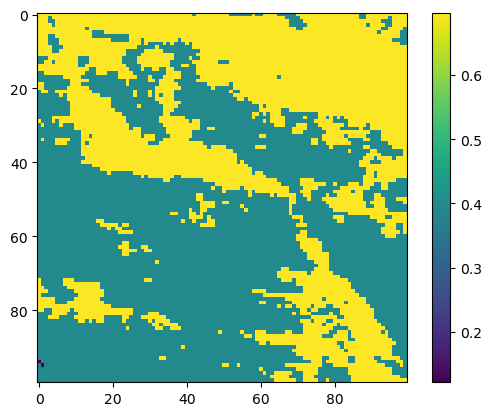

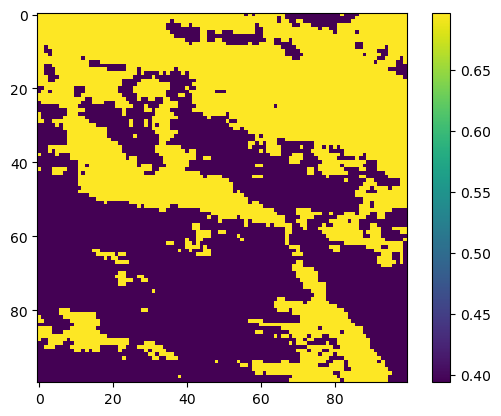

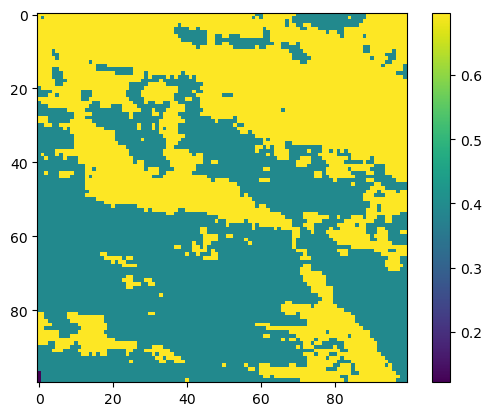

In [17]:
for i in range(0, 3):
    plt.imshow(canopy_tens_norm[i].numpy())
    plt.colorbar()  
    plt.show()

## Herbaceous vegetation

In [18]:
# Path to your TIF file
file_path = '../buffalo_herby_cent50x50_n10000.tif'
# with lag
# file_path = '../buffalo_herby_cent100x100_lag_6hr_n10000.tif'

# Using rasterio 
with rasterio.open(file_path) as herby:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    herby_stack = herby.read([i for i in range(1, herby.count + 1)])

print(herby_stack.shape)      

(9816, 100, 100)


In [19]:
print(herby_stack.shape)
# print(canopy_stack.size)

herby_tens = torch.from_numpy(herby_stack)
print(herby_tens.shape)
print("Mean = ", torch.mean(herby_tens))

herby_max = torch.max(herby_tens)
herby_min = torch.min(herby_tens)

print("Max = ", herby_max)
print("Min = ", herby_min)

# Normalizing the data
herby_tens_norm = (herby_tens - herby_min) / (herby_max - herby_min)
print("Mean = ", torch.mean(herby_tens_norm))
print("Max = ", torch.max(herby_tens_norm))
print("Min = ", torch.min(herby_tens_norm))

# print(herby_tens_norm.dtype)

(9816, 100, 100)
torch.Size([9816, 100, 100])
Mean =  tensor(0.8095)
Max =  tensor(1.)
Min =  tensor(0.)
Mean =  tensor(0.8095)
Max =  tensor(1.)
Min =  tensor(0.)


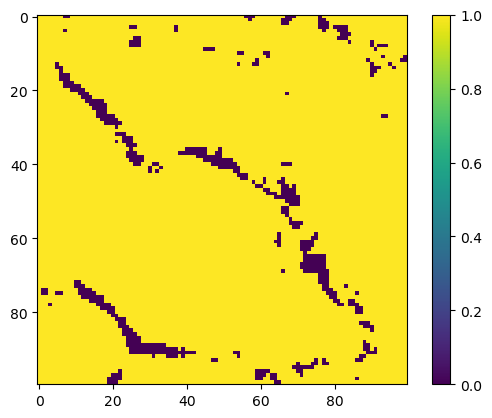

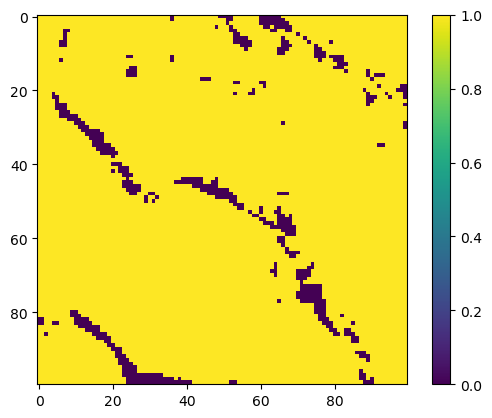

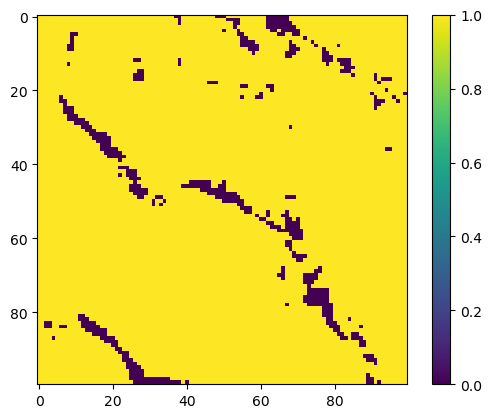

In [20]:
for i in range(0, 3):
    plt.imshow(herby_tens_norm[i])
    plt.colorbar()  
    plt.show()

## Slope

In [21]:
# Path to your TIF file
file_path = '../buffalo_slope_cent50x50_n10000.tif'
# with lag
# file_path = '../buffalo_slope_cent100x100_lag_6hr_n10000.tif'

# Using rasterio 
with rasterio.open(file_path) as slope:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    slope_stack = slope.read([i for i in range(1, slope.count + 1)])

print(slope_stack.shape)

(9816, 100, 100)


In [22]:
print(slope_stack.shape)
# print(canopy_stack.size)

slope_tens = torch.from_numpy(slope_stack)
print(slope_tens.shape)
print("Mean = ", torch.mean(slope_tens))

slope_max = torch.max(slope_tens)
slope_min = torch.min(slope_tens)

print("Max = ", slope_max)
print("Min = ", slope_min)

# Normalizing the data
slope_tens_norm = (slope_tens - slope_min) / (slope_max - slope_min)
print("Mean = ", torch.mean(slope_tens_norm))
print("Max = ", torch.max(slope_tens_norm))
print("Min = ", torch.min(slope_tens_norm))

# print(slope_tens_norm.dtype)

(9816, 100, 100)
torch.Size([9816, 100, 100])
Mean =  tensor(0.7717)
Max =  tensor(12.2981)
Min =  tensor(0.0006)
Mean =  tensor(0.0627)
Max =  tensor(1.)
Min =  tensor(0.)


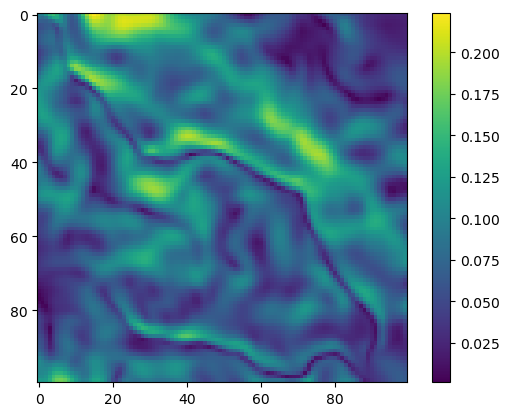

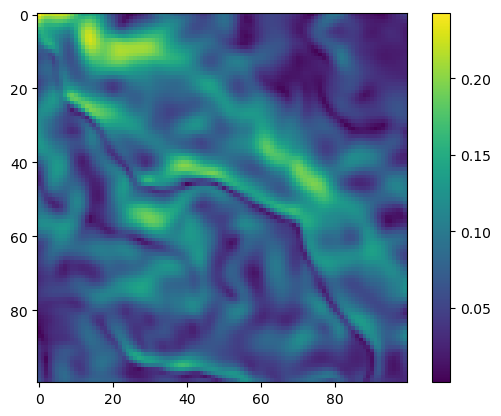

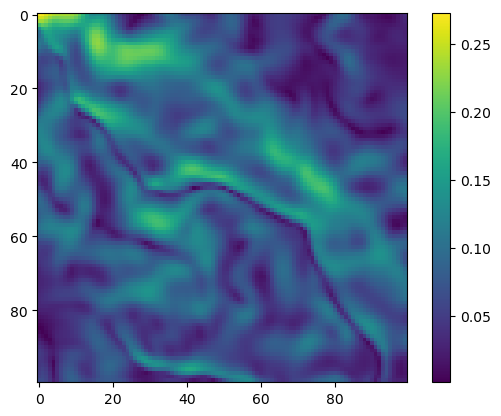

In [23]:
for i in range(0, 3):
    plt.imshow(slope_tens_norm[i])
    plt.colorbar()  
    plt.show()

## Presence records - target of model

In [24]:
# Path to your TIF file
file_path = '../buffalo_pres_cent50x50_n10000.tif'
# with lag
# file_path = '../buffalo_pres_cent100x100_lag_6hr_n10000.tif'

# Using rasterio 
with rasterio.open(file_path) as pres:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    pres_stack = pres.read([i for i in range(1, pres.count + 1)])

print(pres_stack.shape)

(9816, 100, 100)


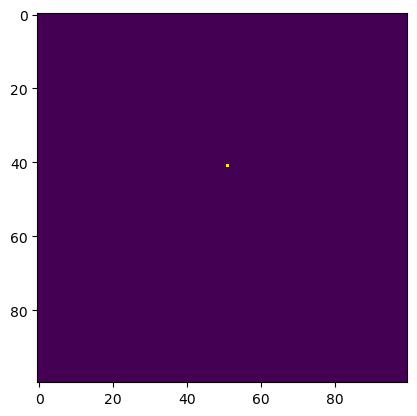

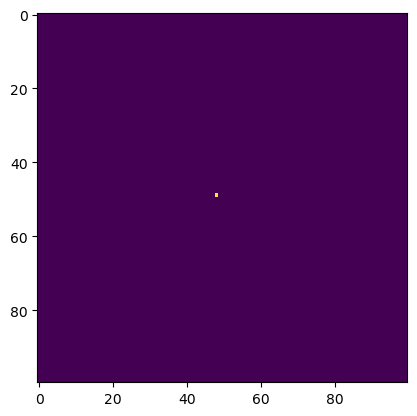

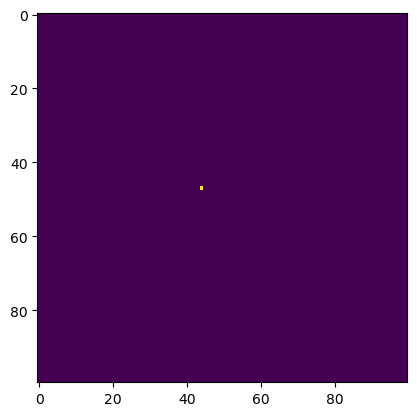

In [25]:
for i in range(0, 3):
    plt.imshow(pres_stack[i])
    plt.show()

Find the index of the occupied cell

In [26]:
# pres_stack
# Find the coordinates of the 1
coordinates = np.where(pres_stack[0] == 1)
print(coordinates)
x, y = coordinates[0][0], coordinates[1][0]
print(x, y)

(array([41], dtype=int64), array([51], dtype=int64))
41 51


In [27]:
# Convert coordinates to single index for CrossEntropyLoss
index = x * 100 + y
print(index)

4151


Now do for all locations

In [28]:
# Iterate over all the layers in the stack and store the coordinates of the 1
indices = []
for i in range(0, pres.count-1):
    # print(i)
    coordinates = np.where(pres_stack[i] == 1)
    x, y = coordinates[0][0], coordinates[1][0]
    index = x * 100 + y
    indices.append(index)


In [29]:
print(indices)
# how many entries in indices
print(len(indices))

[4151, 4948, 4744, 5152, 4842, 5048, 7052, 4949, 5049, 4240, 4615, 4747, 4448, 4949, 4950, 5049, 5445, 6456, 5166, 5050, 5049, 4950, 5367, 6765, 2882, 4043, 4231, 4643, 5142, 6357, 5049, 4950, 5050, 5049, 4343, 3432, 5542, 4349, 5144, 5050, 5049, 4559, 5254, 5964, 4756, 5052, 5242, 4949, 4948, 6258, 4949, 5049, 5047, 6528, 5050, 5049, 5135, 4351, 5360, 5053, 5049, 4950, 5049, 4949, 5050, 4949, 6567, 5963, 2679, 5047, 2115, 6150, 4950, 5050, 5347, 6035, 6360, 4958, 4653, 5050, 5049, 4949, 5042, 4751, 5049, 5049, 6347, 5254, 5252, 4846, 4861, 5048, 6348, 4950, 5049, 4950, 5050, 3854, 6147, 5047, 5050, 4949, 5049, 4950, 5050, 5049, 5745, 8150, 4956, 5052, 5152, 3078, 3344, 7136, 5050, 5049, 4949, 5731, 5333, 5446, 5348, 4751, 5457, 4150, 2741, 4950, 5049, 5049, 4950, 5049, 4158, 3858, 4363, 5153, 5658, 5350, 4346, 5247, 5336, 5047, 5050, 4950, 4226, 5523, 4948, 5859, 5354, 4952, 4949, 5049, 4950, 5051, 5049, 5050, 6451, 6666, 5050, 4861, 773, 4749, 5049, 4745, 4742, 5248, 5945, 5049, 4736

In [51]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


# Starting to build up a model

Combing the data into a TensorDataSet

In [52]:
print(sl_ta[0:800])

tensor([[ 3.9254,  1.3679],
        [ 5.0229, -0.0214],
        [ 4.2579,  2.9949],
        ...,
        [ 3.3013, -2.3890],
        [ 6.5681,  0.2589],
        [ 3.6550,  1.6215]])


Combine the spatial layers into channels

In [53]:
# Stack the channels along a new axis; here, 1 is commonly used for channel axis in PyTorch
# combined_stack = np.stack([ndvi_stack_norm, canopy_stack, herby_stack, slope_stack], axis=1)
combined_stack = torch.stack([ndvi_tens_norm, canopy_tens_norm, herby_tens_norm, slope_tens_norm], dim=1)
combined_stack
print(combined_stack.shape)

torch.Size([9816, 4, 100, 100])


In [54]:
# Convert to a torch tensor (if using as a target for loss calculation)
# target = torch.tensor([indices], dtype=torch.long)

train_prop = 0.8

train_n = round(combined_stack.shape[0] * train_prop)
print(train_n)
# print(combined_stack.shape[0] * (1 - train_prop))

# length of training data (not used)
test_n = round(combined_stack.shape[0] * (1 - train_prop))
print(test_n)

# total length of the training data
total_n = len(sl_ta)
print(total_n)


7853
1963
9815


## Defining data sets and data loaders

In [55]:
# set up some hyperparameters
bs = 10

# train_ds = TensorDataset(torch.from_numpy(combined_stack[0:train_n]), torch.tensor(indices[0:train_n], dtype=torch.long))
# print(train_ds)
# print(train_ds.tensors)
# train_dl = DataLoader(train_ds, batch_size=bs, shuffle = True)

# convert to a tensor
# sl_ta = torch.tensor(sl_ta[0:train_n], dtype=torch.float32)
# print(sl_ta)

train_ds = TensorDataset(combined_stack[1:train_n], torch.tensor(sl_ta[1:train_n], dtype=torch.float32))
print(train_ds)
print(train_ds.tensors)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle = True)

test_ds = TensorDataset(combined_stack[train_n:total_n], torch.tensor(sl_ta[train_n:total_n], dtype=torch.float32))
# print(train_ds)
# print(train_ds.tensors)
test_dl = DataLoader(test_ds, batch_size=bs, shuffle = True)


(tensor([[[[4.8878e-01, 5.0427e-01, 5.1804e-01,  ..., 5.2991e-01,
           5.2507e-01, 5.4302e-01],
          [4.8743e-01, 5.1039e-01, 5.2550e-01,  ..., 5.2828e-01,
           5.1934e-01, 5.2885e-01],
          [4.8886e-01, 5.0768e-01, 5.2779e-01,  ..., 5.2623e-01,
           5.2775e-01, 5.2949e-01],
          ...,
          [4.3785e-01, 4.5565e-01, 4.6424e-01,  ..., 4.7096e-01,
           4.6142e-01, 4.7240e-01],
          [4.4064e-01, 4.4329e-01, 4.4577e-01,  ..., 4.7342e-01,
           4.6309e-01, 4.7222e-01],
          [4.5125e-01, 4.6241e-01, 4.5263e-01,  ..., 4.7598e-01,
           4.6696e-01, 4.5727e-01]],

         [[6.9697e-01, 6.9697e-01, 6.9697e-01,  ..., 6.9697e-01,
           6.9697e-01, 6.9697e-01],
          [6.9697e-01, 6.9697e-01, 6.9697e-01,  ..., 6.9697e-01,
           6.9697e-01, 6.9697e-01],
          [6.9697e-01, 6.9697e-01, 6.9697e-01,  ..., 6.9697e-01,
           6.9697e-01, 6.9697e-01],
          ...,
          [3.9394e-01, 3.9394e-01, 3.9394e-01,  ..., 3.939

C:\Users\n11207361\AppData\Local\Temp\ipykernel_22476\2290201630.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_ds = TensorDataset(combined_stack[1:train_n], torch.tensor(sl_ta[1:train_n], dtype=torch.float32))
C:\Users\n11207361\AppData\Local\Temp\ipykernel_22476\2290201630.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_ds = TensorDataset(combined_stack[train_n:total_n], torch.tensor(sl_ta[train_n:total_n], dtype=torch.float32))


In [56]:
print(train_dl)
print(train_dl.dataset.tensors[0].shape)
print(test_dl.dataset.tensors[0].shape)

print(train_dl.dataset.tensors[1].shape)
print(test_dl.dataset.tensors[1].shape)

torch.Size([7852, 4, 100, 100])
torch.Size([1962, 4, 100, 100])
torch.Size([7852, 2])
torch.Size([1962, 2])


## Define the model

In [57]:
class ConvNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_model = nn.Sequential(
            # input Nx4x200x200, output Nx16x100x100
            nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, stride=1, padding=1),
            # same dimensions
            nn.ReLU(),
            # # will reduce dimensions by half to Nx16x50x50
            nn.MaxPool2d(kernel_size=2, stride=2),
            # input Nx16x50x50, output Nx32x50x50
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            # same dimensions
            nn.ReLU(),
            # # will reduce dimensions by half to Nx32x25x25
            nn.MaxPool2d(kernel_size=2, stride=2),
            # flatten to vectors of Nx20000
            nn.Flatten(1,-1),
            nn.Linear(32*25*25, 1000),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(1000, 100),
            nn.Dropout(),
            nn.ReLU(),
            # nn.Linear(100, 100),
            # nn.Dropout(),
            # nn.ReLU(),
            nn.Linear(100, 2)
        )

    def forward(self, x):
        logits = self.cnn_model(x)
        return logits
        
        # pred_probab = nn.Softmax(dim=1)(logits)
        # return pred_probab
    





In [ ]:
class ConvJointModel(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.cnn_model_habitat = nn.Sequential(
            self.
            self.input_channels = params.input_channels
            self.output_channels = params.output_channels
            self.kernel_size = params.kernel_size
            self.stride = params.stride
            self.padding = params.padding

            nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, stride=1, padding=1),
            # same dimensions
            nn.ReLU(),
            # # will reduce dimensions by half to Nx16x50x50
            nn.MaxPool2d(kernel_size=2, stride=2),
            # input Nx16x50x50, output Nx32x50x50
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            # same dimensions
            nn.ReLU(),
            # # will reduce dimensions by half to Nx32x25x25
            nn.MaxPool2d(kernel_size=2, stride=2),
            # flatten to vectors of Nx20000
            nn.Flatten(1,-1),
            nn.Linear(32*25*25, 1000),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(1000, 10000)
        )
        self.cnn_model_movement = nn.Sequential(
            # input Nx4x200x200, output Nx16x100x100
            nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, stride=1, padding=1),
            # same dimensions
            nn.ReLU(),
            # # will reduce dimensions by half to Nx16x50x50
            nn.MaxPool2d(kernel_size=2, stride=2),
            # input Nx16x50x50, output Nx32x50x50
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            # same dimensions
            nn.ReLU(),
            # # will reduce dimensions by half to Nx32x25x25
            nn.MaxPool2d(kernel_size=2, stride=2),
            # flatten to vectors of Nx20000
            nn.Flatten(1,-1),
            nn.Linear(32*25*25, 1000),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(1000, 100),
            nn.Dropout(),
            nn.ReLU(),
            # nn.Linear(100, 100),
            # nn.Dropout(),
            # nn.ReLU(),
            nn.Linear(100, 2)
        )
    def params_to_grid(params):
        logit_grid = torch.zeros(())
        return logit_grid

    def forward(self, x):
        logits_habitat = self.cnn_model_habitat(x)
        params_movement = self.cnn_model_movement(x)
        logits_movement = self.params_to_grid(params_movement)
        logits_all = torch.stack((logits_habitat, logits_movement), dim = 0)
        return logits_all #logits_all will be a 4D tensor
        #return logits
        
        # pred_probab = nn.Softmax(dim=1)(logits)
        # return pred_probab
    
        

Take a look at the model's structure

In [58]:
model = ConvNeuralNetwork().to(device)
print(model)

ConvNeuralNetwork(
  (cnn_model): Sequential(
    (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=20000, out_features=1000, bias=True)
    (8): Dropout(p=0.5, inplace=False)
    (9): ReLU()
    (10): Linear(in_features=1000, out_features=100, bias=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): ReLU()
    (13): Linear(in_features=100, out_features=2, bias=True)
  )
)


In [59]:
X = torch.rand(1, 4, 100, 100, device=device)
# logits = model(X)
pred_probab = model(X)
# pred_probab = nn.Softmax(dim=1)(logits)
# y_pred = pred_probab.argmax(1)
# print(f"Predicted class: {y_pred}")

In [60]:
pred_probab

# image = pred_probab.view(100, 100).detach().cpu().numpy()
# plt.imshow(image)  # 'cmap' can be adjusted based on your data
# plt.colorbar()  # Optionally add a colorbar to see the scale
# # plt.title('Output Image')
# plt.show()

tensor([[ 0.0029, -0.0618]], grad_fn=<AddmmBackward0>)

In [61]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: cnn_model.0.weight | Size: torch.Size([16, 4, 3, 3]) | Values : tensor([[[[-0.0398,  0.0537, -0.0832],
          [-0.0696, -0.1346,  0.1038],
          [-0.1065,  0.0730, -0.0430]],

         [[-0.1596,  0.1216,  0.0953],
          [-0.1517, -0.0669,  0.0015],
          [ 0.0600, -0.1146,  0.1139]],

         [[-0.0764,  0.0486,  0.1101],
          [ 0.0843, -0.0417, -0.1564],
          [-0.0249,  0.0641, -0.1482]],

         [[ 0.0990,  0.0363,  0.0755],
          [ 0.1177,  0.0648, -0.0062],
          [-0.1017,  0.1474, -0.0365]]],


        [[[ 0.0011, -0.0617,  0.0777],
          [ 0.0852,  0.0098, -0.0268],
          [-0.0570, -0.0239, -0.0708]],

         [[-0.0331,  0.0920, -0.0583],
          [ 0.0098,  0.1208,  0.0077],
          [ 0.0803, -0.0210,  0.1398]],

         [[-0.0450,  0.1397, -0.0920],
          [ 0.0613, -0.0151,  0.1525],
          [ 0.1639, -0.0451,  0.1071]],

         [[ 0.1260, -0.1374,  0.0443],
          [-0.0576, -0.1583, -0.1393],
          [-0.13

## Loss function and optimizer

In [62]:
# Initialize the loss function

# for multiclass classification
# loss_fn = nn.CrossEntropyLoss()

# for regression of step lengths and turning angles
loss_fn = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training loop

In [63]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Flatten the target tensor 'y'
        # y_flattened = y.view(y.shape[0], -1)

        # Compute prediction and loss
        # pred = model(X)
        # loss = loss_fn(pred, y_flattened)
        # loss = loss_fn(model(X), y.view(y.shape[0], -1))

        # with cross entropy loss
        loss = loss_fn(model(X), y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * bs + len(X)
            print(f"loss: {loss:>15f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            # pred = model(X)
            # test_loss += loss_fn(model(X), y.view(y.shape[0], -1)).item()
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            # with cross entropy loss
            test_loss += loss_fn(model(X), y)

    test_loss /= num_batches
    # correct /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print(f"Avg loss: {test_loss:>15f} \n")

## Train the model

In [64]:
# learning_rate = 1e-1
batch_size = bs # does not actually affect the batch size - this should be changed prior to creating the dataloader object
epochs = 1

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dl, model, loss_fn, optimizer)
    test_loop(test_dl, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss:       12.157793  [   10/ 7852]
loss:        3.486981  [  110/ 7852]
loss:        3.255824  [  210/ 7852]
loss:        3.275558  [  310/ 7852]
loss:        2.646168  [  410/ 7852]
loss:        3.605868  [  510/ 7852]
loss:        3.188545  [  610/ 7852]
loss:        2.486010  [  710/ 7852]
loss:        5.341877  [  810/ 7852]
loss:        4.008557  [  910/ 7852]
loss:        4.323055  [ 1010/ 7852]
loss:        5.421446  [ 1110/ 7852]
loss:        1.697026  [ 1210/ 7852]
loss:        4.487840  [ 1310/ 7852]
loss:        3.081397  [ 1410/ 7852]
loss:        3.734629  [ 1510/ 7852]
loss:        2.872571  [ 1610/ 7852]
loss:        6.512822  [ 1710/ 7852]
loss:        4.333365  [ 1810/ 7852]
loss:        4.125135  [ 1910/ 7852]
loss:        3.045750  [ 2010/ 7852]
loss:        2.571562  [ 2110/ 7852]
loss:        4.343202  [ 2210/ 7852]
loss:        4.208005  [ 2310/ 7852]


In [ ]:
print(model.state_dict())

OrderedDict([('cnn_model.0.weight', tensor([[[[ 9.3181e-02, -1.6154e-01, -1.0430e-01],
          [-1.0728e-01, -8.0202e-02, -1.6414e-01],
          [ 6.7282e-02, -1.3038e-01,  3.6704e-02]],

         [[-4.7005e-02,  4.9636e-02, -8.7653e-02],
          [-1.5629e-01, -7.3407e-02, -4.8392e-02],
          [ 7.9324e-02, -2.1192e-02,  2.4123e-02]],

         [[-1.3203e-01, -9.0254e-02,  9.2056e-02],
          [-1.3604e-01, -1.2906e-01,  8.3248e-02],
          [-4.0925e-02, -1.7658e-01, -3.6127e-02]],

         [[-4.0105e-02,  1.0711e-01,  9.5873e-02],
          [-3.9322e-02, -1.8662e-02, -1.4808e-02],
          [ 2.2241e-02,  8.7605e-02, -1.3285e-01]]],


        [[[-1.1294e-01,  1.1727e-01, -2.6026e-02],
          [-4.6419e-02, -3.6362e-02, -2.2359e-01],
          [-1.3349e-01, -1.9613e-01,  1.0298e-02]],

         [[-1.1179e-01, -1.1336e-01, -1.9937e-01],
          [-9.3999e-02,  5.3740e-02, -1.9203e-01],
          [ 1.0302e-01, -2.5316e-02, -1.8408e-01]],

         [[-1.6432e-01, -6.7538e

## Generate predictions

torch.Size([1, 4, 100, 100])


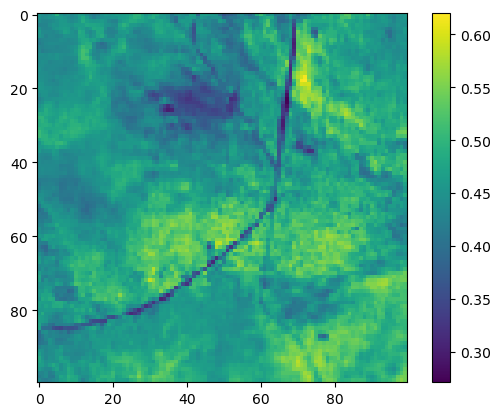

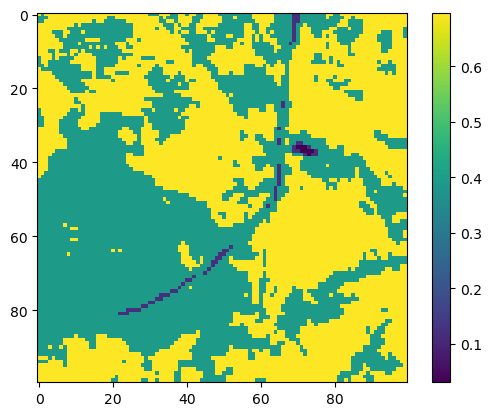

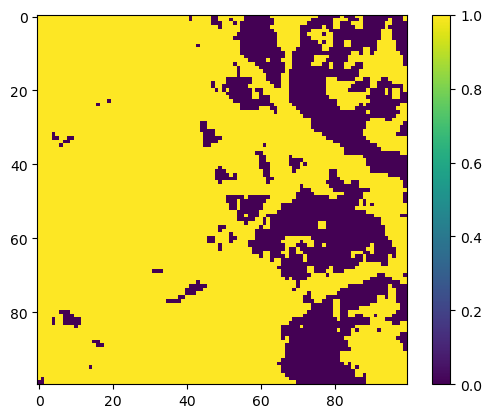

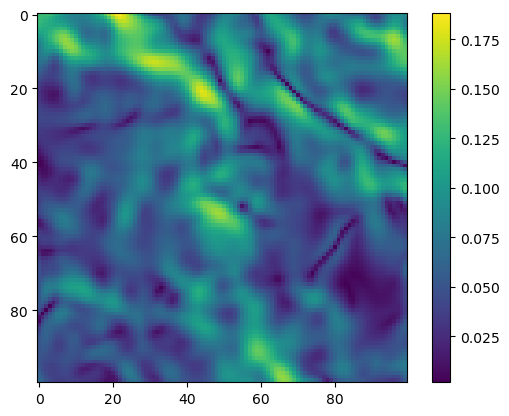

In [ ]:
# 1. Set the model in evaluation mode
model.eval()

# 2. Setup the inference mode context manager
# with torch.inference_mode():
#   # 3. Make sure the calculations are done with the model and data on the same device
#   # in our case, we haven't setup device-agnostic code yet so our data and model are
#   # on the CPU by default.
#   # model_0.to(device)
#   # X_test = X_test.to(device)
#   y_preds = model(X_test)
# y_preds

pred_x = train_dl.dataset.tensors[0][3000,:,:,:].unsqueeze(0)
print(pred_x.shape)

for i in range(0, 4):
    plt.imshow(pred_x[0, i].numpy())
    plt.colorbar()  
    plt.show()

# Display the plot
plt.show()

In [ ]:
with torch.no_grad():
  logits = model(pred_x)
logits

tensor([[108.3540,   0.2908]])

## Predict next step

Looping over training data

In [ ]:
# 1. Set the model in evaluation mode
model.eval()

for i in range(0, 100):

  pred_x = train_dl.dataset.tensors[0][i*10,:,:,:].unsqueeze(0)
  pred_y = train_dl.dataset.tensors[1][i*10].unsqueeze(0)

  with torch.no_grad():
    logits = model(pred_x)
  print(logits)


tensor([[112.9670,   0.3044]])
tensor([[108.1753,   0.2917]])
tensor([[107.4488,   0.2897]])
tensor([[111.2305,   0.2993]])
tensor([[110.6339,   0.2980]])
tensor([[111.2305,   0.2993]])
tensor([[107.7297,   0.2893]])
tensor([[112.4803,   0.3031]])
tensor([[110.5990,   0.2970]])
tensor([[112.8929,   0.3042]])
tensor([[111.2305,   0.2993]])
tensor([[110.4891,   0.2975]])
tensor([[108.3680,   0.2919]])
tensor([[109.1773,   0.2943]])
tensor([[111.2305,   0.2993]])
tensor([[107.3570,   0.2894]])
tensor([[113.0013,   0.3043]])
tensor([[108.6700,   0.2937]])
tensor([[111.6251,   0.3009]])
tensor([[110.4233,   0.2970]])
tensor([[109.2448,   0.2949]])
tensor([[110.0884,   0.2951]])
tensor([[110.4247,   0.2966]])
tensor([[111.5177,   0.3000]])
tensor([[110.5575,   0.2970]])
tensor([[109.4027,   0.2950]])
tensor([[107.7297,   0.2893]])
tensor([[111.9456,   0.3017]])
tensor([[111.5485,   0.3009]])
tensor([[110.4692,   0.2965]])
tensor([[109.4027,   0.2950]])
tensor([[110.1033,   0.2961]])
tensor([